# Final Project - Display Advertising Challenge
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

__`Andy Carlson, Mark Gin, Michelle Liu, Kathleen Wang`__

## 1. Question Formulation

Display advertising is a type of online advertising that comes in several forms, including banner ad, text billboard, or videos. Display advertising is a billion dollar effort and marketers are always thriving for the most optimal way to target their potential customers.

In this Kaggle competition, CriteoLabs provided a week’s worth of data on the user and the page he is visiting to develop models predicting ad click-through rate (CTR). Given the metrics CriteoLabs collected on the user and the page, our goal is to develop an accurate machine learning algorithm for CTR estimation to predict if the user would click on the ad. 

### 1.1 Background

We downloaded the large dataset from CriteoLabs:

* train.csv - This file contains 45,840,617 rows, consisting of a portion of Criteo's data over a period of 7 days. Each row corresponds to a display ad, where positive (clicked) and negatives (non-clicked) examples have both been subsampled at different rates to reduce the dataset size. 

* test.csv - The test set for Kaggle submission purposes is computed in the same way as the training set but for events on the day following the training period.

In the data, the first column is a label that indicates if the ad was clicked (1) or not (0). The next 39 columns are undisclosed features - the first 13 columns are integer features, and the next 26 columns are categorial features that are hashed onto 32 bits for anonymization purposes. The fields are left empty when a value is missing.

Since around 75% of the data are labeled 0, our goal is to beat 75% accuracy for our algorithm to be practically useful.

## 2. EDA  & Discussion of Challenges

In this analysis, we will explore the Criteo Ad data to support our predictive modeling. Analysis of data heuristics will provide insight on which models might perform well, which hyperparameters to choose, and speculate on the overall difficulty of the undertaking. The EDA will commence with 3 sections:

1. Data quality and distribution
2. Statistics of the most prevalent instances of categorical data
3. Systematic differences in features per label

The Criteo Display Advertising dataset that we are provided contains:

1. Data labels
2. Columns 1-13 are numerical data
3. Columns 14-26 are categorical (string) data

All the data has been anonamized, which provides some challenges in of itself, as we will not be able to use any direct human intuition as part of our feature selection. Aspects we'll want to explore about the data will include checks for missing data points and consideration remedies for missing fields as well as cross-correlation of variables with missing data.

We'll also want to investigate the number categories distribution for the categorical data. This will be particularly useful in helping to determine if we need to do additional feature engineering and can affect our strategy for predicting labels.

Similar to the categorical data, we want to investigate the distribution of each numerical data field; this can also help guide our decision making on how best to predict Ad Click-Through based on the data provided.

### 2.1 Setting up

In [1]:
%%bash
pip install missingno

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
from operator import add
from collections import defaultdict
import csv
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, classification_report

from scipy.stats import chi2_contingency
import seaborn as sb
import matplotlib.pyplot as plt
import missingno as msno

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel, LabeledPoint, RandomForest

plt.style.use("ggplot")

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "w261_final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

### 2.2 Loading Data

Sample the data from the cluster and load some of it into memory. We set our sample size to 10,000 to allow us for easier interpretation of the dataset, as a 40 million entry analysis would be cumbersome for a full analysis. This is sampled randomly, so it can be considered an unbiased estimator for many of the heuristics about the data.

In [5]:
rawRDD = spark.read.csv("data/train.txt", header=False, sep="\t").rdd
dataRDD = rawRDD.map(lambda row: ([None if el is None else int(el) for el in row[1:14]] \
                                  + list(row[14:]), int(row[0]))).cache()

In [6]:
n = 10000
sample = dataRDD.takeSample(withReplacement=False, num=n)

numeric_columns = np.array([pair[0][:13] for pair in sample], dtype=np.float)
numeric_df = pd.DataFrame(numeric_columns)

category_columns = np.array([pair[0][13:] for pair in sample])
category_df = pd.DataFrame(category_columns)

labels = np.array([pair[1] for pair in sample])

### 2.3 Data Quality and Distribution

#### 2.3.1 Analyze 13 Numeric Columns

First, see the fraction of missing values for each column. We notice that some are complete, or near complete. Others are mostly missing. 

In [8]:
pd.DataFrame(numeric_df.isna().sum() / n).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.4477,0.0,0.2169,0.2248,0.0243,0.22,0.041,0.0007,0.041,0.4477,0.041,0.7597,0.2248


Let's also visualize that. This will help to see if the missing values are correlated. Gray means not missing and white means missing.

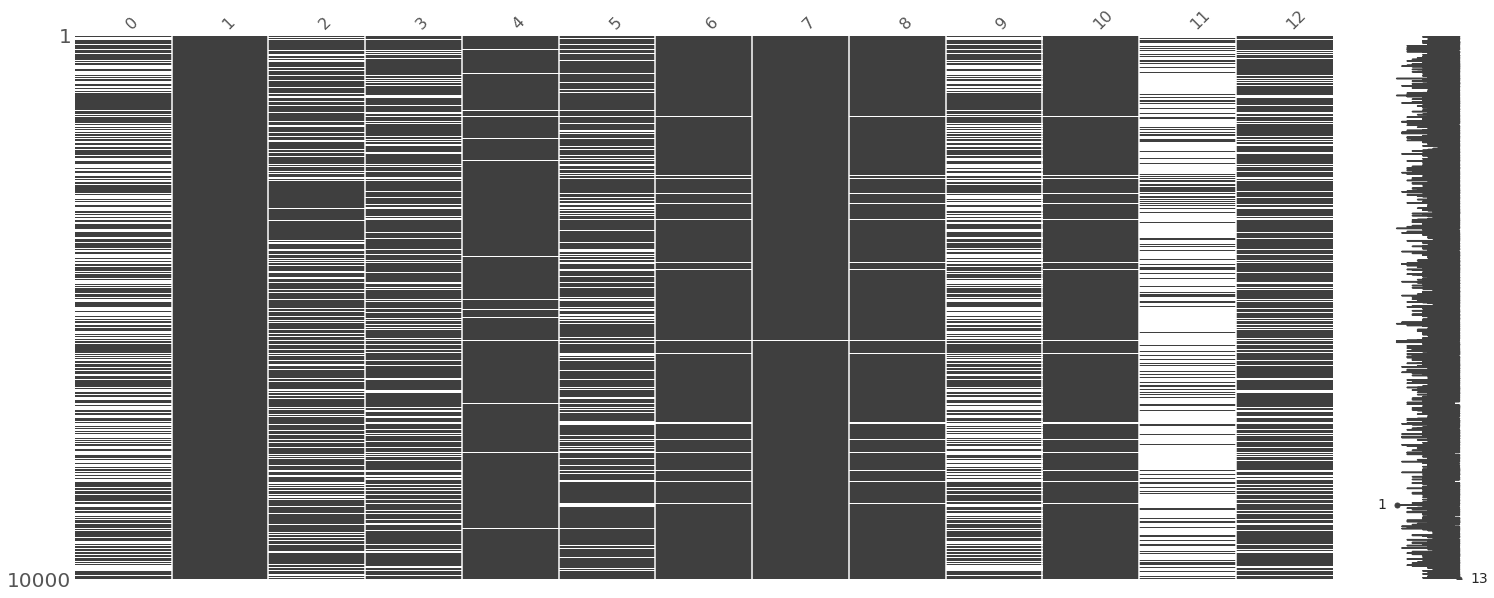

In [9]:
# plot positions of missing values
msno.matrix(numeric_df);

This shows that between some columns, the missing values are correlated, i.e. a value missing in one column affects whether the value is missing oin another. Columns I6 and I8 are perfectly correlated. Others appear to have little correlation. This means removing rows with missing data is infeasible, as it would eliminate nearly the entire dataset.

Next, look at the spread of the values which are present, such as histograms.

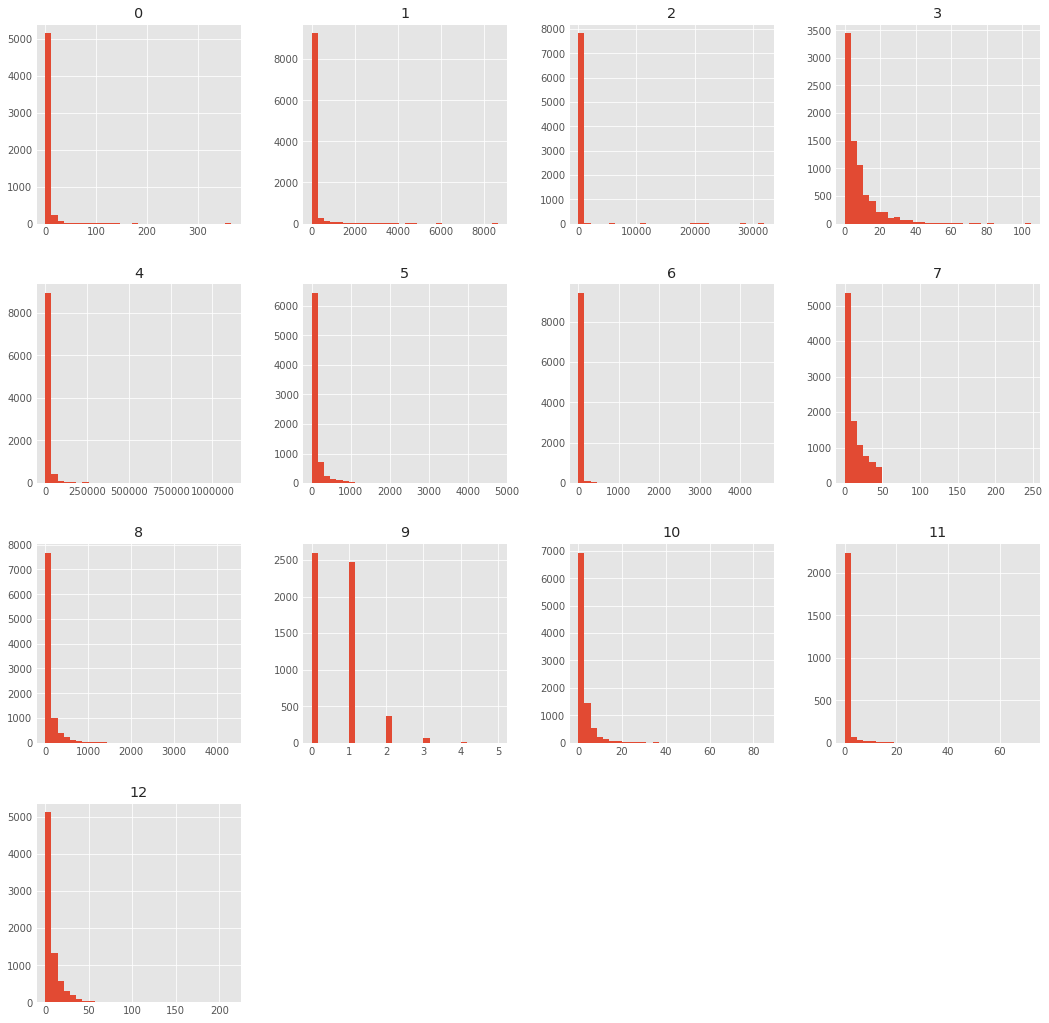

In [10]:
numeric_df.hist(figsize=(18, 18), bins=30);

These are all very right-skewed. This can be undesireable for some models. In order to get more normal looking distributions with transforms, we also look at a log-transform (and add constant value to avoid issues with 0's). The result looks more normal, but the prevalence of 0-values produces a flagrant bi-modality. It would be better to avoid the need for transformation, if practical.

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


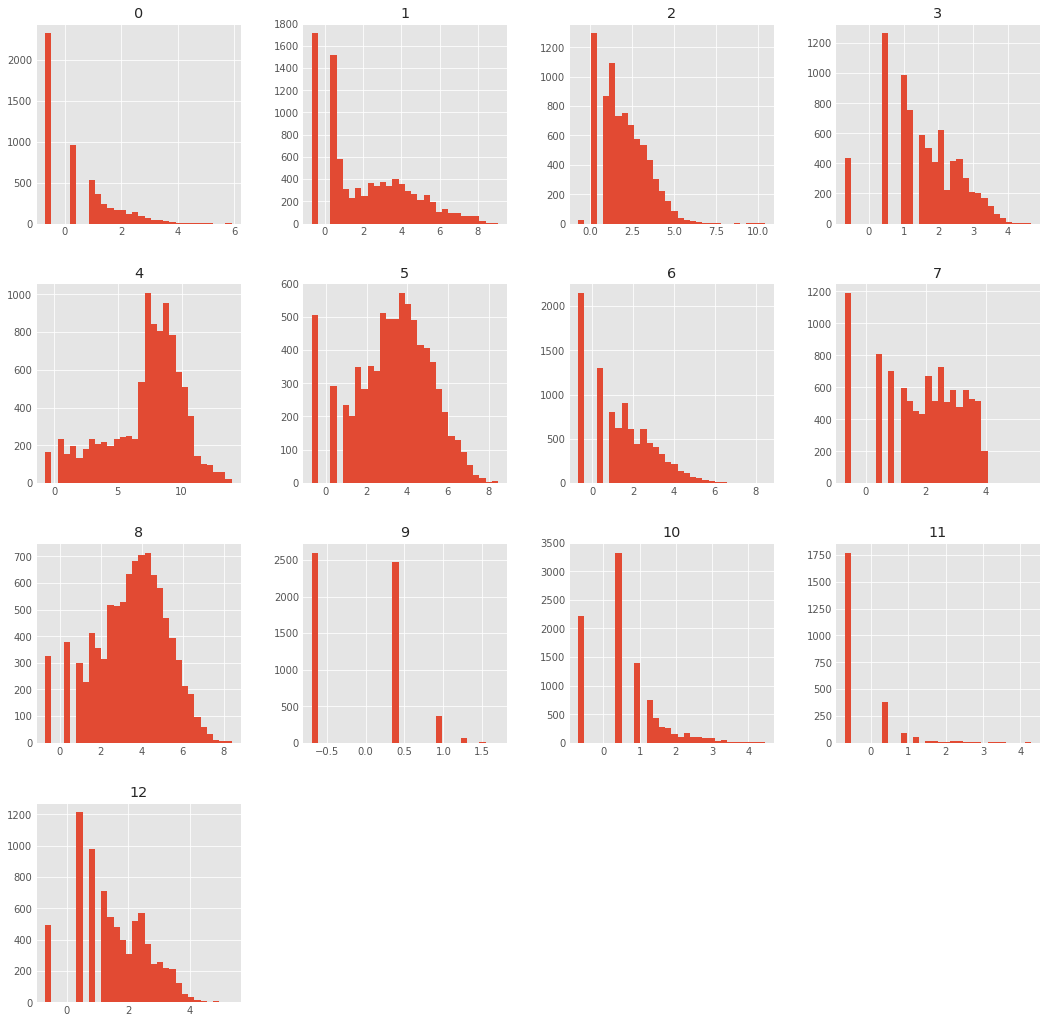

In [11]:
np.log(numeric_df + 0.5).hist(figsize=(18, 18), bins=30);

Now let's look at some other aggregate statistics, like quantiles, means, and extremes. This can be used to check for anomalies and potential coding errors. We notice some negative values, but this seems like a very isolated, one-off occurences, and can probably be ignored.

In [12]:
numeric_df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,5523.0,3.568351,10.015372,0.0,0.0,1.0,3.00,366.0
1,10000.0,105.922600,384.466408,-2.0,0.0,3.0,37.25,8664.0
2,7831.0,38.536841,650.096696,0.0,2.0,6.0,18.00,32008.0
3,7752.0,7.287410,8.541502,0.0,2.0,4.0,10.00,105.0
4,9757.0,18232.677770,69007.992281,0.0,305.0,2780.0,9970.00,1113600.0
5,7800.0,111.453462,254.773201,0.0,8.0,32.0,103.00,4771.0
6,9590.0,17.359437,82.399171,0.0,1.0,3.0,12.00,4599.0
7,9993.0,12.392375,13.196688,0.0,2.0,7.0,19.00,247.0
8,9590.0,109.805422,227.980120,0.0,10.0,39.0,112.00,4330.0
9,5523.0,0.625747,0.681868,0.0,0.0,1.0,1.00,5.0


Finally, we check if there is collinearity within our data. Only a few features seem to be correlated with each other, which means there aren't many redundant features.

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


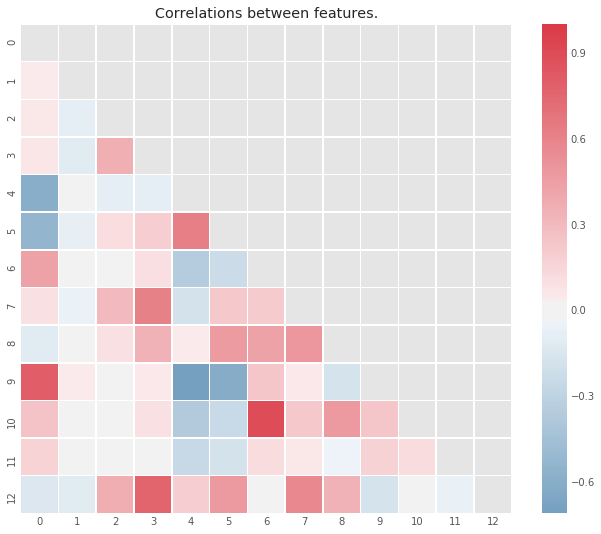

In [13]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = np.log(numeric_df + 0.5).corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sb.diverging_palette(240, 10, as_cmap=True)
sb.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

#### Insights

Luckily, the data seems free of coding errors and redundant features. However, there is a lot of missing data, and removing examples with NULL values is impossible. We would also like to avoid having to transform the feature values. Choosing a model that can easily handle NULLs and be scale-invariant seems judicious. Models based on decision trees are promising candidates in this regard.

#### 2.3.2 Analyze 26 Categorical Columns

Again, we start by looking for missing values. The categorical data is more complete, and the missing values are more correlated. However, we already know that removing any NULLs is infeasible.

In [14]:
# get percent of missing values for each column

null_df = pd.DataFrame(category_df.isna().sum() / n).T
display(null_df[list(range(0, 15))])
null_df[list(range(15, 26))].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0353,0.0353,0.0,0.1194,0.0,0.0,0.0,0.0,0.0,0.0353,0.0,0.0,0.0


,15,16,17,18,19,20,21,22,23,24,25
0,0.0353,0.0,0.0,0.4364,0.4364,0.0353,0.7652,0.0,0.0353,0.4364,0.4364


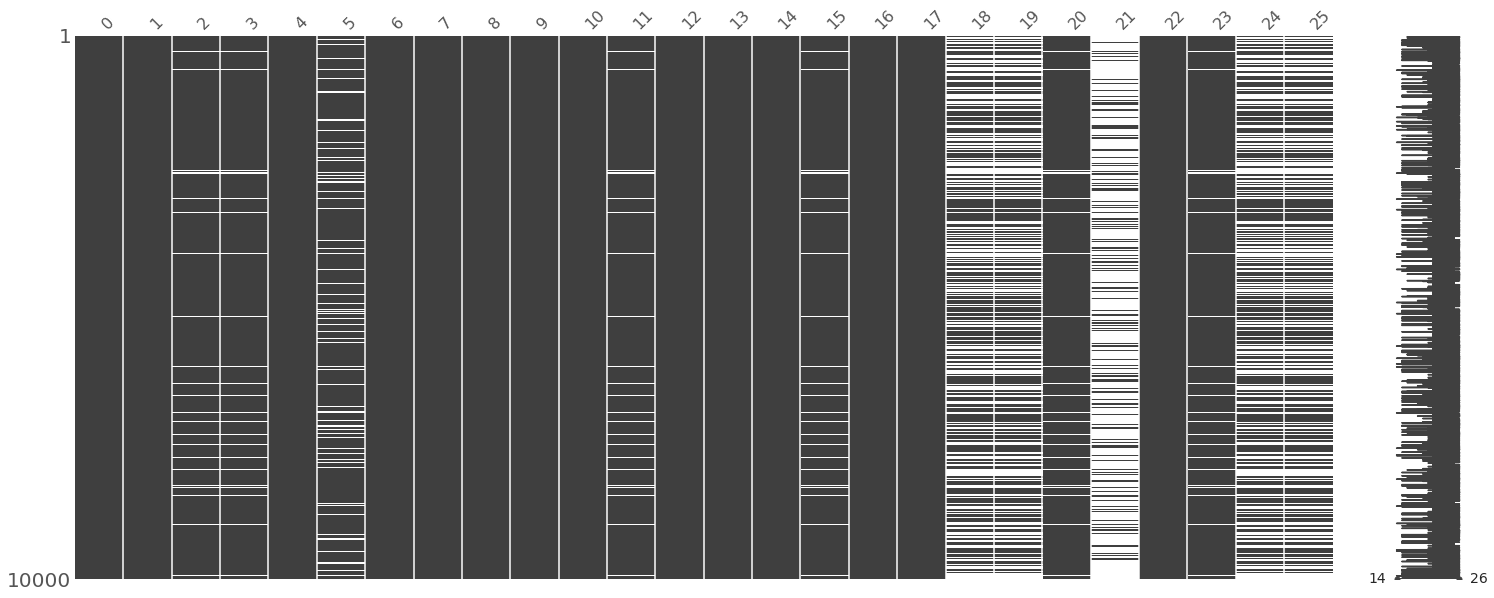

In [15]:
# plot positions of missing values
msno.matrix(category_df);

Next, we want to get an idea of the distribution of the categories. Here, we plot the counts of all the categories that appear in the `C0` column. We see that there are a large number of rare catergories. This is not good, as we need many appearances of a category in order to train parameters on it.

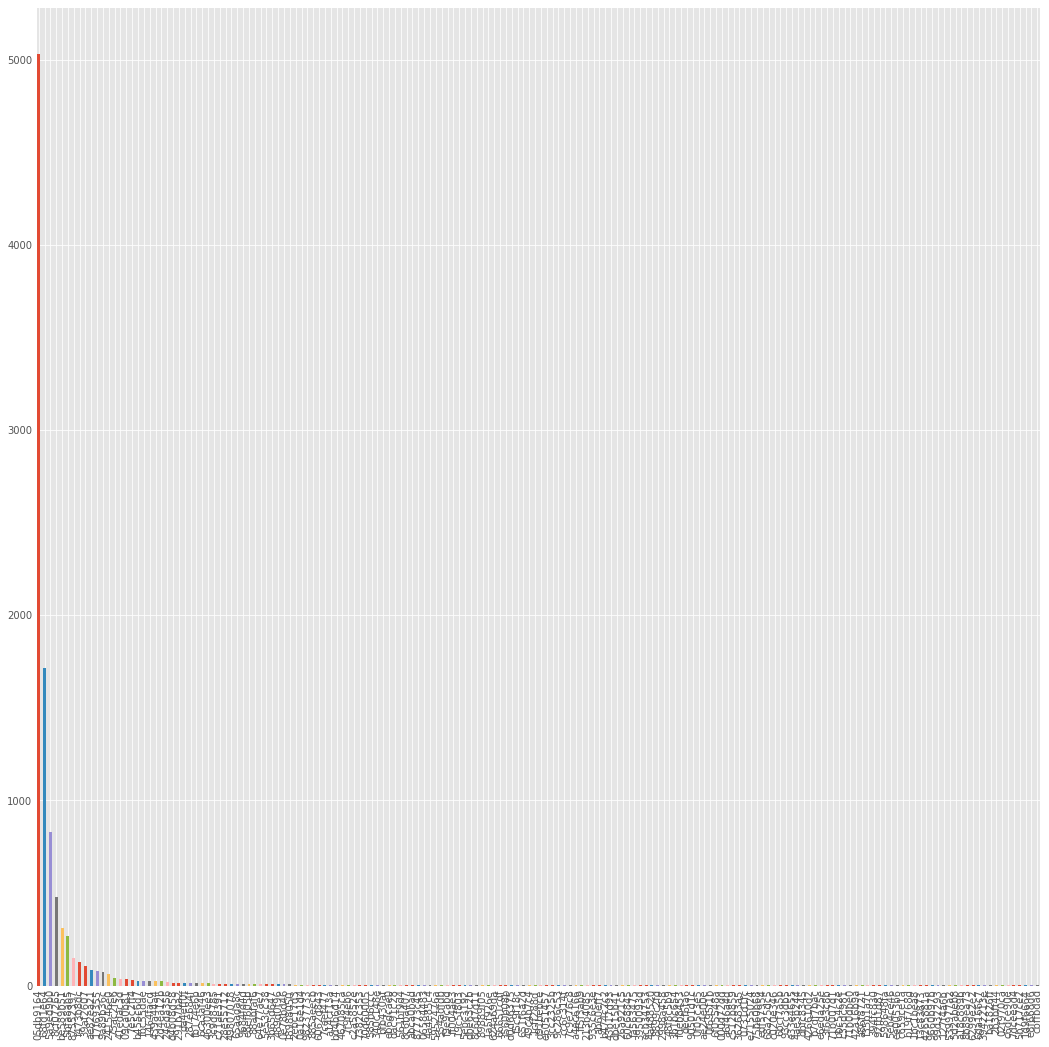

In [16]:
# plot counts for all the possible values of the first column. there are too many categories that appear 
#only once!
counts = pd.value_counts(category_df[0]).plot(kind="bar", figsize=(18, 18))

The table below shows more counts for other columns. The "rare category" issue is pretty widespread. Several columns have a very high number of unique columns, and the top most common category is sometimes relatively rare itself (sometimes lower than 0.03% of the examples).

In [17]:
category_df.describe().T

,count,unique,top,freq
0,10000,172,05db9164,5034
1,10000,396,38a947a1,1160
2,9647,5932,d032c263,210
3,9647,4227,c18be181,311
4,10000,53,25c83c98,6710
5,8806,7,7e0ccccf,3987
6,10000,3312,1c86e0eb,210
7,10000,106,0b153874,5925
8,10000,3,a73ee510,9024
9,10000,3297,3b08e48b,2161


Next, we plot histograms for the counts. This shows how common this rare-category problem is across the features, as more columns have a huge number of rare classes (classes with a low count). The only ones that seem reasonable to train with are C5, C8, C13, C16, C19, C21, C22, and C24.

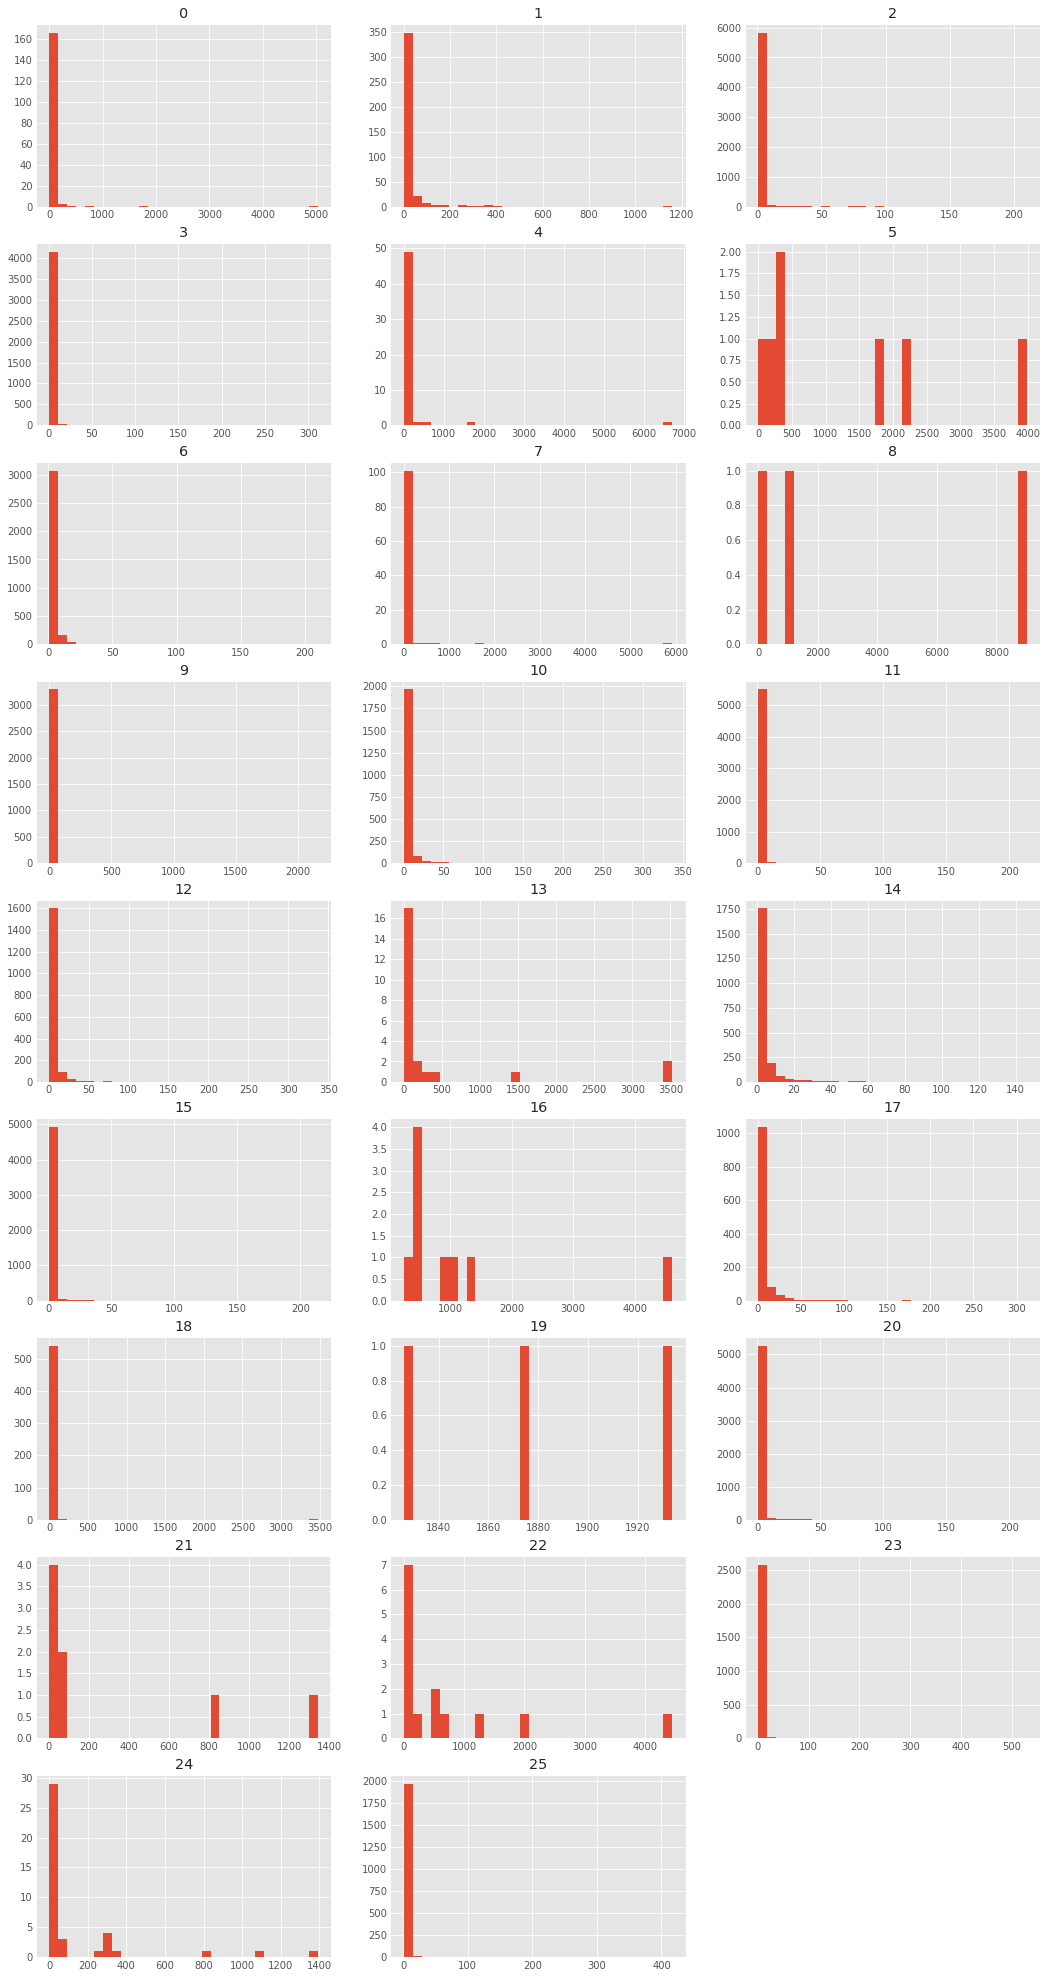

In [18]:
plt.figure(figsize=(18, 4 * len(category_df.columns)))
for i in category_df:
    counts = pd.value_counts(category_df[i])
    plt.subplot(len(category_df.columns), 3, i + 1)
    plt.hist(counts.values, bins=30)
    plt.title(i)

#### Insights

Most of the datapoints here are rare categories. Due to the lack of data on them, we cannot use the full variety of categories to train on. Instead, we'll retain only the top-n most common categories within each column, replacing all others with one special value indicating a rare category.

#### 2.3.3 Analyze Labels

Finally, we analyze the distribution of the labels. This shows that almost 75% of the examples are negative (not clicked). Since the classes are imbalanced, we need to ensure our evaluation metrics give proper attention to the positive class. Accuracy won't be adequate as the recall and F1 scores for the positive class need to be considered. Resampling or weighting may be required to prevent bias.

In [19]:
np.mean(labels)

0.2617

### 2.4 Get Top-N Categories for Each Column

In order to figure out which categories are common or "non-rare" for each column, we count up all the categories, filter out any that occur fewer than 10 times, and get the 50 most frequent categories. Then during training, all the other categories will be replaced with the value `"RARE"`. We save the categories we selected to a CSV file which can be reloaded later.

In [20]:
n = 50

def emit_categories(pair):
    """
    takes each row, and emits one record per categorical column. Emits in a key-value format with 2 tuples:
    (column_name, category_hash), (count_false, count_true, total_count)
    
    count_false is 1 if this row has a 0 label
    count_true is 1 if this row has a 1 label
    these two aren't necessary, but nice to know if the category shows up more frequently in a particular class
    total_count is always 1
    
    these numbers will get reduced and added later
    """
    row, label = pair
    # only loop over the categorical variables
    for i, val in enumerate(row[13:]):
        yield ("C" + str(i), val), (int(label == 0), int(label == 1), 1)

def shift_key(pair):
    """take a 2-tuple key, and make it 1 value instead"""
    (col_name, val), (neg_count, pos_count, total) = pair
    return col_name, (val, neg_count, pos_count, total)

def get_top_n(n):
    """for each group, get the top n by total_count"""
    def mapper(val_seq):
        val_seq = sorted(val_seq, key=lambda x: x[-1], reverse=True)
        return val_seq[:n]
    return mapper
        
category_counts = dataRDD.flatMap(emit_categories) \
    .reduceByKey(lambda tup_a, tup_b: (tup_a[0] + tup_b[0], tup_a[1] + tup_b[1], tup_a[2] + tup_b[2])) \
    .filter(lambda pair: pair[1][-1] >= 10) \
    .map(shift_key) \
    .groupByKey() \
    .mapValues(get_top_n(n)).cache()

num_significant_categories = category_counts.mapValues(len)

In [21]:
category_count_data = defaultdict(dict)

with open("data/freq_category_counts.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["col_name", "category", "neg_count", "pos_count", "total", "category_id"])
    
    # stream the results in to the master
    for row in category_counts.toLocalIterator():
        col_name, category_info = row
        # loop through all the categories and assign an integer ID for each, and save that to the CSV as well
        category_id = 0
        for info in category_info:
            category_name, neg_count, pos_count, total = info
            category_count_data[col_name][category_name] = { "neg": neg_count, "pos": pos_count }
            writer.writerow([col_name, category_name, neg_count, pos_count, total, category_id])
            category_id += 1

Furthermore, we need to know how many categories remain after this filtering (some have fewer than 50). We need to save this too, as sometimes the "arity" of the column needs to be specified for training.

In [22]:
with open("data/num_significant_categories.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["field", "count"])
    for row in num_significant_categories.toLocalIterator():
        writer.writerow(row)

### 2.5 Correlation with Target

Finally, we check if the values are distributed differently within each class label. Ideally, we would see some values occur much more commonly in one particular class, as it means we should be able to use that feature for a prediction.

For the numeric columns, we make two box plots for each,partitioned by label. Upon initial visual inspection, there does seem to be some systematic differences across classes.

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


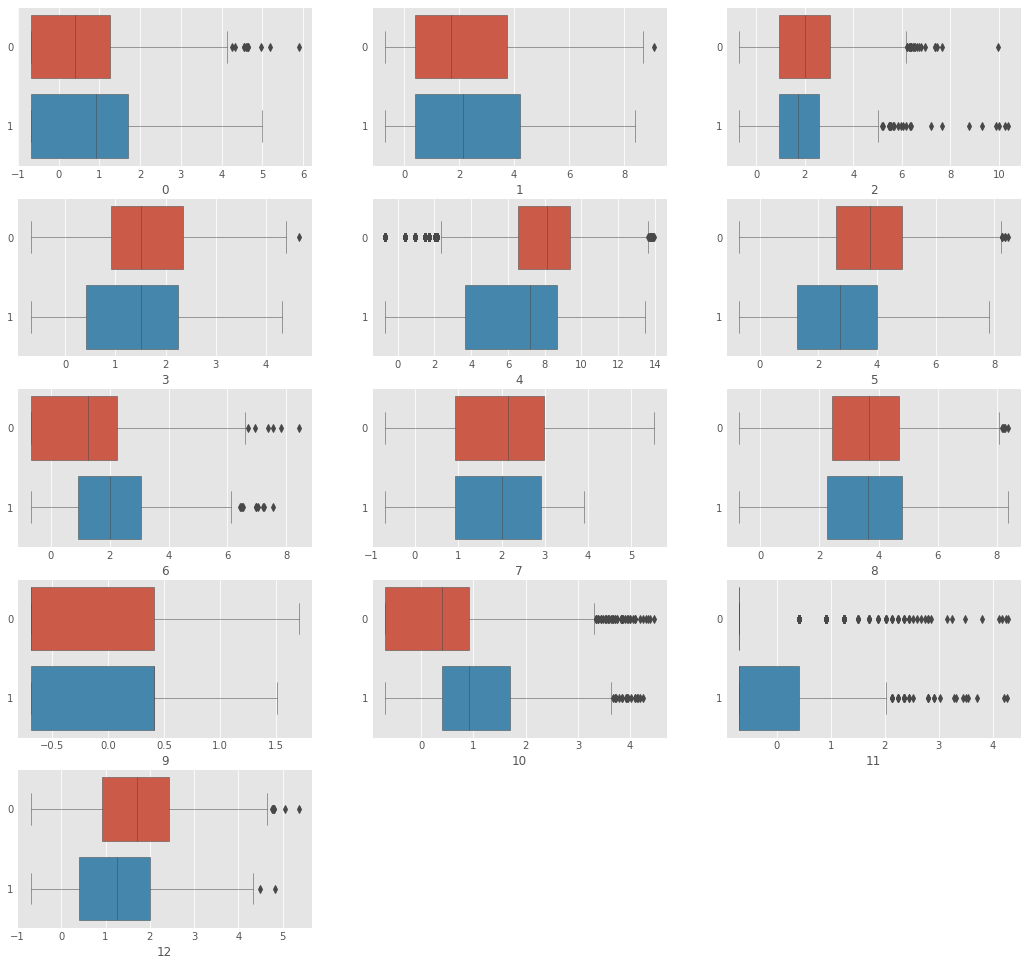

In [23]:
plt.figure(figsize=(18, 45))
for i in numeric_df:
    x = numeric_df[i]
    plt.subplot(len(numeric_df.columns), 3, i + 1)
    sb.boxplot(np.log(x + 0.5), labels, orient="h", linewidth=0.5)

plt.show()

Lastly, we check if the distributions of categories are different per class. For categorical data, this can be accomplished with a χ² test. This test assumes that the 2 groups are independent (null hypothesis). First, we put the category distributions in a [contingency table](https://en.wikipedia.org/wiki/Contingency_table). Then, we compare each distribution with the "expected distribution", and add up the differences to get the chi-statistic. This number follows a χ² distribution. We can compute a p-value as potential evidence against the null hypothesis.

Most of the p-values are 0 or very close to 0. This means there are differences in the distributions of categories per class. This is good news, as it suggests we might use these to make a prediction. 

Note that we are slightly skeptical of this result since the χ² test rejects the null hypothesis too easily when there are some very small counts. Since there are a lot of rare categories, many of these columns have this *long tail* of rare counts. This may reject the null hypothesis, but would not imply prospects for predictive modeling.

In [24]:
col_names = []
chi2s = []
p_vals = []

for col_name, category_counts in category_count_data.items():
    neg_distribution = np.array([counts["neg"] for counts in category_counts.values()])
    pos_distribution = np.array([counts["pos"] for counts in category_counts.values()])
    chi2, p_val, _, expected = chi2_contingency([neg_distribution, pos_distribution])
    col_names.append(col_name)
    chi2s.append(chi2)
    p_vals.append(p_val)

chi2_test_df = pd.DataFrame({ "column": col_names, "χ²": chi2s, "p value": p_vals })
chi2_test_df

,column,χ²,p value
0,C13,7.309380e+05,0.000000
1,C2,7.072835e+05,0.000000
2,C20,6.809812e+05,0.000000
3,C1,9.167635e+05,0.000000
4,C18,2.326288e+05,0.000000
5,C23,7.363631e+05,0.000000
6,C21,5.812026e+04,0.000000
7,C14,5.640432e+05,0.000000
8,C8,4.617091e+05,0.000000
9,C6,8.213768e+05,0.000000


### 2.6 Summary of Insights from EDA

- Some columns have no nulls or very few, while others have many. Sometimes columns have nulls correlated with other columns. We won't be able to simply omit rows with missing data. In order to avoid having to impute meaningful values, we can use decision-tree-based models for their ability to handle NULLs.
- Most numerical values are very right-skewed. This is another good reason to chose decision trees, as they don't require transformation of the data.
- There are some outlying negative values in the second integer column, but it's a very small percentage. This can be ignored. There don't seem to be any coding errors.
- There is little correlation bewteen the numerical columns. This is good, as it means there is little redundancy.
- The categorical columns consist mostly of a disarrangement of rare cetegories, i.e. most of the unique categories only show up in the data few times. We can take all the rare categories and replace them with a special value (keeping only the top-k categories in each column), but that will remove some useful information while introducing another hyper-parameter, k.
- The classes are imbalanced. About 75% of the examples are negative. This will cause the models we train to favor high accuracy on the majority class unless we can weight the examples or re-sample.
- Not much evidence of any columns correlating strongly with the target, unfortunately.

## 3. Algorithm Explanation

### 3.1 Algorithm Comparison

In [34]:
from IPython.display import Image
Image(filename="images/Model Comparison.PNG")

FileNotFoundError: [Errno 2] No such file or directory: 'images/Model Comparison.PNG'

Since **decision trees** are easy to understand, simple to demonstrate and serves at the basis for two other powerful algorithms while remaining scalable, we will demonstrate the basic of decision trees in the following section.

### 3.2 Key Concepts

To build a tree, we need a iterative process that create binary splits at each node, choosing from a list of possible splits. After a split is chosen, we go down each path of the split and further split the data using this iterative process. We will stop when the termination criteria is met.

**Biase Variance Tradeoff**
Given enough depth, our tree can fit the data perfectly by memorizing every data point. For the purpose of preventing overfitting, we can either stop growing tree after a few iterations or stop when there are less than $n$ data left in the branch.

**Information Gain and Entropy**
Since this is a classification problem, one frequently used metric to choose a split among all possible splits is to look at the information gain if that split is chosen. Information gain is the reduction in entropy - a measure of uncertainty. For example, if choosing a split results in 50% 0's and 50% 1's, we effectively gained no knowledge from this split, and hence the entropy is 1.

$$
\text{Entropy:  }  
H(x) = -(p_1log(p_1)+p_2log(p_2))
$$

Information gain at each node means after applying one split at this node, how much more information did we get out of it. It is the difference between entropy at the root node $H_0$ and the weighted entropy at the left and right nodes  $p_1*H_1 + p_2*H_2$. When choosing among a list of possible splits, we are essentially selecting the split that gives us the minimum entropy

### 3.3 Tree building steps

**1. Design: Parallelize across data and across frontier:**

Decision trees can easily be parallelized. The data can be processed seperately because we will only need the total counts in different categories. If we were to report on variance, we cannot calculate variances directly because it is not an **associative and commutative process**, changing the data order would change the result. To accurately report out variance, we will have to reduce the data to sums and counts and calculate the variance seperately.

Furthermore, as we go down the tree, we can build the entire frontier, i.e. each level of the tree in one interation since the data points should be cleanly seperated in each nodes in the same frontier. In other words, we can parallelize along each frontier when we build an entire tree layer in each iteration.

**2. Initilize and Broadcast:**

In order to build tree, we need three pieces of information:

1. current tree structure
2. frontier: what nodes are we building in this iteration
3. split list: what are the possible splits These three are small relative to the dataset and will be broadcast to all the clusters.

After each iteration, all three must be updated and rebroadcasted with the new split information.

**3. Map record to counts:**

For each record, decide which node the record is in. Then for each of the possible splits, decide if this record satisfies the split i.e. $split=1$, and also decide if the y-value is 1, or both. These are the values needed for the entropy calculation


**4. Sum up counts, calculate entropy:**

From the mapped output, we can compute for each node_id + split_id key, the total counts associated with each possible split. With that, we can calculate weighted entropy for each possible split. More specifically:

$$
H_{split1} = -(p_{y_1|split_1}logp_{y_1|split_1}+p_{y_0|split_1}logp_{y_0|split_1})\\ 
H_{split0} = -(p_{y_1|split_0}logp_{y_1|split_0}+p_{y_0|split_0}logp_{y_0|split_0}) \\
p_{y_1|split_1} = \frac{\text{count of y = 1 for those with split = 1}}{\text{count of those with split = 1}}\\
$$

Then we further reduce by selecting, for each node, the split that produces the minimum entropy.


**5. Update tree structure, frontier and split list:**

After finding the best splits for all the nodes in the frontier, we have to update the existing tree. We need information on the path to each node, its children, the value it split on and etc. There are efficient ways to achieve that, but for this demo we saved the entire path for each node so that we can easily read them.

**6. Stop growing tree if creteria are met**

To prevent overfitting and in the interest of run time, we can either stop growing tree after a few iterations or stop when there are less than $n$ data left in the branch.

### 3.4 Toy Example

[TODO: What toy example shoudl we use?]

## 4. Algorithm Implementation

### 4.1 Feature Hashing

Due to the massive feature space for categorical data (as realized in our EDA), we will implement a hashing trick. This will do two things for us, the first is to convert the anonamized categorical data from strings into a numeric type. The next, in order to reduce the feature space, we apply a hash function, in this case a simple modulus operation, to reduce the feature size to 16 bits. Since the data is anonamized, it is impractical to come up with a "logical" hash function to group "like" categories, so in order to reduce our feature space and improve our model run-time, this will suffice. Working with real, non-anomamized data, we would approach this in a more practical manner.

In [25]:
# define the hash trick to convert string features to numeric and reduce the feature space
# take a row of features and the label
# leave features 0-13 the same (already integers), convert and hash features 
def hashTrick(features, label, N):
    newFeatures = list(features[0:13])
    for i in range(14, len(features)):
        if features[i] == None:
            newFeatures += list([None])
        else:
            newFeatures += list([int(features[i], 16) % 2**N])
    yield (newFeatures, label)

### 4.2 Data Engineering

In our models, the numerical columns are pretty much used directly. Note that NULLs are encoded with the value -10 (also tried 0 and imputing with the medians). Categorical values are kept if they are in the common categories from the EDA. They were assigned an integer ID, which is in the frequent_feats dict. This is used to encode each value. All rare values are converted to a special ID. NULLs are converted to yet another special ID. Note that this adds 2 additional categories from the ones we picked from the EDA.

First, we transform our input data into the features so the output is a LabeledPoint object.

In [ ]:
# load the data we saved from the EDA. This helps us engineer the features and configure the model

frequent_feats = {}

with open("data/freq_category_counts.csv") as csvfile:
    for row in csv.DictReader(csvfile):
        total = int(row["total"])
        if total >= 10:
            key = "{}-{}".format(row["col_name"], row["category"])
            frequent_feats[key] = int(row["category_id"])

with open("data/num_significant_categories.csv") as csvfile:
    num_significant_categories = { row["field"]: int(row["count"]) for row in csv.DictReader(csvfile) }

In [28]:
def to_labeled(pair):
    """transform input data into the features"""
    row, label = pair
    # collect the converted values here
    vector = []
    
    for i, val in enumerate(row):
        # if this is an numerical column
        if i < 13:
            if val is None:
                val = -10
        # if this is categorical
        else:
            if val is not None:
                key = "C{}-{}".format(i - 13, val)
                # if its one of our "common" values
                if key in frequent_feats:
                    # look up its ID
                    val = frequent_feats[key]
                else:
                    # give it the special value for RARE
                    val = num_significant_categories["C" + str(i - 13)]
            else:
                # give it the special value for NULL
                val = num_significant_categories["C" + str(i - 13)] + 1
        vector.append(val)
    return LabeledPoint(label, vector)

def resample(pair):
    """sample the positive examples twice to increase their importance"""
    if pair.label == 1:
        return [pair, pair]
    else:
        return [pair]

In [36]:
labeledRDD = dataRDD.map(to_labeled)

# set model params
categoricalFeaturesInfo = { int(feat[1:]) + 13: count + 2 for feat, count in num_significant_categories.items() }
maxBins = max(num_significant_categories.values()) + 2
trainingData, validationData = labeledRDD.randomSplit([0.9, 0.1])
# re-samples the positive class
#trainingData = trainingData.flatMap(resample)

labels = validationData.map(lambda lp: lp.label).collect()

### 5.2 Homegrown Implementation

To achieve scalability, we decided to use MLlib implementaion of Random Forest. However, we develop a "homegrown" implementation of the tree in Spark and run it on our toy dataset. 

[TODO: Insert Andy's updated version of home grown tree]

[TODO: Per James: Talk about what needs to be parallelized and how it can be vs what makes something difficult from an engineering prospective]

### 5.3 MLlib Implementation

With MLlib, we experimented with different trees with different parameters to tune our model.

#### 5.3.1 Gradient Boosted Trees

In [ ]:
def trainGBT(trainingData, maxBins, maxDepth, numIterations):

    model_gbdt = GradientBoostedTrees.trainClassifier(trainingData,
                                                      categoricalFeaturesInfo={},
                                                      maxBins=maxBins,
                                                      maxDepth=8,
                                                      numIterations=10) # how many trees

    # Evaluate model on test instances and compute validation accuracy
    predictions_gbdt = model_gbdt.predict(validationData.map(lambda x: x.features))
    #labelsAndPredictions = validationData.map(lambda lp: lp.label).zip(predictions)
    #testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(validationData.count())

    preds_gbdt = predictions_gbdt.collect()
    accuracy_gbdt = np.mean(np.array(labels) == np.array(preds_gbdt))
    print('accuracy = ' + str(accuracy_gbdt))

    model_name = "models/gbdt-model"
    # save the model
    !rm -rf /media/notebooks/{model_name}
    model_gbdt.save(sc, model_name)

    # how to load the model again, tho not necessary in this file
    #sameModel = GradientBoostedTreesModel.load(sc, model_name)
    #print(sameModel.toDebugString())
    
    return (labels, preds_gbdt)

In [ ]:
# loop through various combinations of tree depth, bins, and iterations
# this will help us hone in on which parameters to use for our final model
for td in range(3,12,3):
    for b in range(10, maxBins,5):
        for i in range(5,12,4):
            print("Depth = " + str(td) + ", Max Bins = " + str(b) + ", Iterations = " + str(i))
            (labels, preds_gbdt) = trainGBT(trainingData, b, td, i)
            print(classification_report(labels, preds_gbdt))
            print(confusion_matrix(labels, preds_gbdt))
            print("")

From training with Gradiented Boosted Tree with different parameters, the highest accuracy we got from the model is 0.77.

#### 5.3.2 Random Forest

In [ ]:
def trainRF(trainingData, maxBins, numClasses, maxDepth, numTrees):
    model_rf = RandomForest.trainClassifier(trainingData,
                                        categoricalFeaturesInfo={},
                                        maxBins=maxBins,
                                        numClasses=numClasses,
                                        maxDepth=maxDepth,
                                        numTrees=numTrees)

    # Evaluate model on test instances and compute validation accuracy
    predictions_rf = model_rf.predict(validationData.map(lambda x: x.features))

    preds_rf = predictions_rf.collect()
    accuracy_rf = np.mean(np.array(labels) == np.array(preds_rf))
    print('accuracy = ' + str(accuracy_rf))

    model_name = "models/rf-model"
    # save the model
    !rm -rf /media/notebooks/{model_name}
    model_rf.save(sc, model_name)
    
    return (labels, preds_rf)

#trainRF(trainingData, maxBins, 2, 15, 10)

In [ ]:
for b in range(maxBins, maxBins+1):
    for d in range(5,26,3):
        for t in range(10,51,5):
            print("Max Bins = " + str(b) + ", Max Depth = " + str(d) + ", Num Trees = " + str(t))
            (labels, preds_rf) = trainRF(trainingData, b, 2, d, t)
            print(classification_report(labels, preds_rf))
            print(confusion_matrix(labels, preds_rf))
            print("")

From training the Random Forest modelw ith varying parameters, the highest accuracy we got is 0.78.

[TODO: Add a section discussing the results from the 2 trees]

### 5.4 Running on the full dataset

Earlier, we sampled only 10,000 rows from the full dataset. Now 

In [29]:
dataRDD.flatMap(lambda r: hashTrick(r[0], r[1], 16)).cache()

In [ ]:
fullLabeledRDD = dataRDD.map(to_labeled)

# set model params
#TODO: need this for full data
categoricalFeaturesInfo = { int(feat[1:]) + 13: count + 2 for feat, count in num_significant_categories.items() }
maxBins = max(num_significant_categories.values()) + 2
fullTrainingData, fullValidationData = labeledRDD.randomSplit([0.9, 0.1])
# re-samples the positive class
#trainingData = trainingData.flatMap(resample)

labels = fullValidationData.map(lambda lp: lp.label).collect()

## 6. Applications of Course Concepts

[TODO: polish the conclusion]

1. bias variance tradeoff / model complexity / regularization (pruning, stopping criteria, random forest instead of gradient boost)

2. associative/commutative operations (we can't compute variance as metric directly because it's not a/c)

3. broadcasting / caching / DAGs / lazy evaluation (tree structures are broadcast in the spark job)

4. preserving the graph structure / additional payloads (yup, we do that)

5. One Hot Encoding / vector embeddings / feature selection (yup, we do that as well)

6. normalization (we can talk about the lack of the need for it in trees)